In [131]:
# importing libraries 

import os
import glob
import cv2
import re
import numpy as np
import pandas as pd
from pathlib import Path
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential 
from keras.layers import InputLayer, Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense , BatchNormalization, GlobalAveragePooling2D,Input,AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model
from keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2
!pip install keras-retinanet
import keras_retinanet
from keras_retinanet import layers
from keras_retinanet.layers import UpsampleLike
from keras.initializers import RandomNormal
from keras import optimizers
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import random 
import albumentations as A

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cat_list = sorted(os.listdir('/content/Combined'))
print(len(cat_list),',', cat_list)

class_no = len(cat_list)

32 , ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Field', 'Forest', 'Grass', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'RailwayStation', 'Resident', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']


In [7]:
dirpath = ('/content/Combined')

all_images = []
for image_class in os.listdir(dirpath): 
    for image in os.listdir(os.path.join(dirpath, image_class)):
        image_path = os.path.join(dirpath, image_class, image)
        all_images.append(image_path)

all_labels = []
for ruta, carpetas, filenames in os.walk(dirpath):
    for filename in filenames:
        # all_labels.append()
        for cat in cat_list:
            if cat==ruta.split('/')[-1]:
                all_labels.append(cat_list.index(cat))

IDs = []
for i in range(len(all_labels)):
    IDs.append('ID_'+str(i))

zipped = list(zip(IDs, all_images, all_labels))
df = pd.DataFrame( zipped , columns=['ID','image','label'] )

In [ ]:
df

,ID,image,label
0,ID_0,/content/Combined/Viaduct/viaduct_261.jpg,31
1,ID_1,/content/Combined/Viaduct/viaduct (55).jpg,31
2,ID_2,/content/Combined/Viaduct/viaduct_41.jpg,31
3,ID_3,/content/Combined/Viaduct/viaduct (23).jpg,31
4,ID_4,/content/Combined/Viaduct/viaduct_243.jpg,31
...,...,...,...
13344,ID_13344,/content/Combined/BaseballField/baseballfield_...,2
13345,ID_13345,/content/Combined/BaseballField/baseballfield_...,2
13346,ID_13346,/content/Combined/BaseballField/baseballfield_...,2
13347,ID_13347,/content/Combined/BaseballField/baseballfield_...,2


In [8]:
def visualize(image):
    plt.figure(figsize=(5, 3))
    plt.axis('off')
    plt.imshow(image)

In [9]:
def show_image_batch(data_iterator, num_images=4, figsize=(20,20)):
    batch = data_iterator.next()
    fig, ax = plt.subplots(ncols=num_images, figsize=figsize)
    for idx, img in enumerate(batch[0][:num_images]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(cat_name(batch[1][idx]))

In [10]:
def cat_name(cat_list):
    for i in cat_list:
        if i==1:
            return class_names[list(cat_list).index(i)]

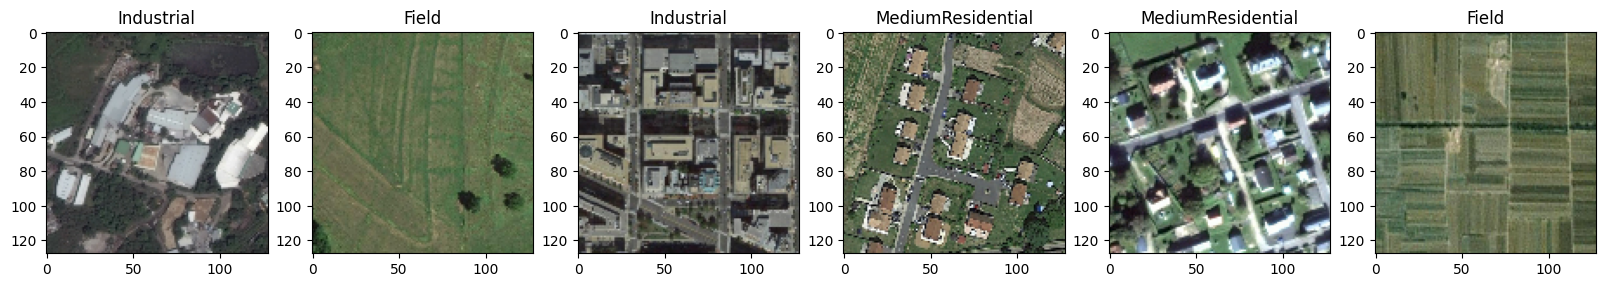

In [ ]:
train_ds_iterator = train_ds.as_numpy_iterator()
show_image_batch(train_ds_iterator,6)

BaseballField is tagged least no of times: 220
River is tagged max no of times: 866


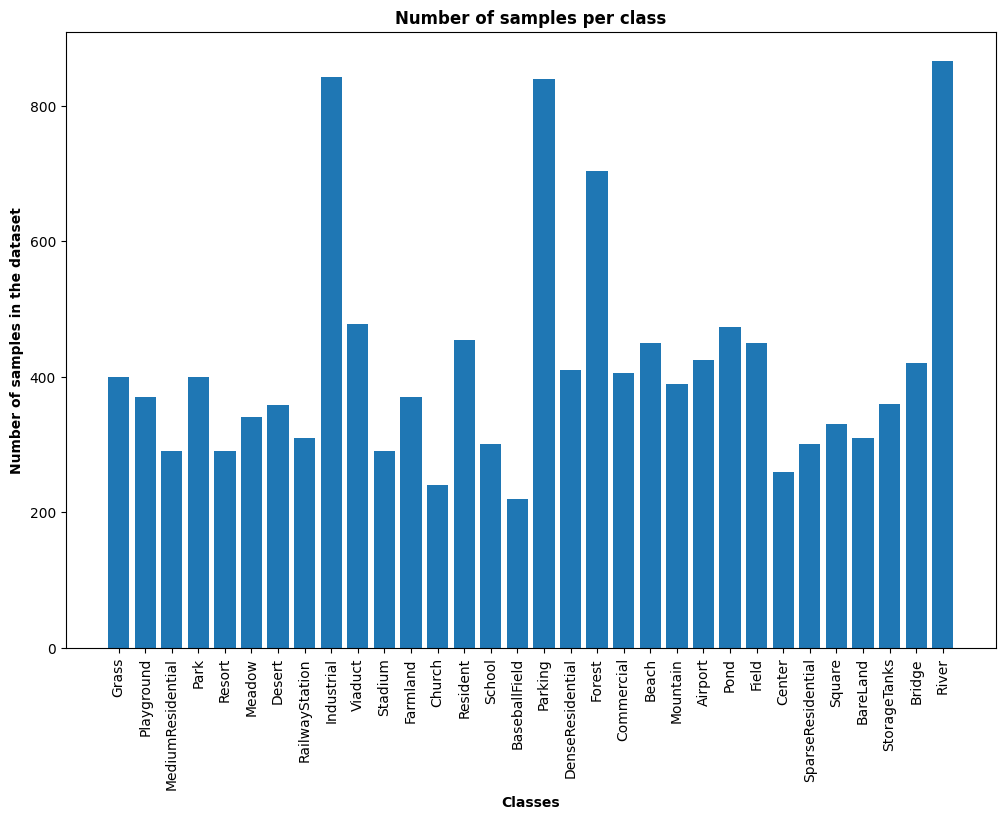

In [ ]:
imgpath = dirpath + os.sep
all_labels = []
for ruta, carpetas, filenames in os.walk(imgpath):
    for filename in filenames:
        all_labels.append(ruta.split('/')[-1])

#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for label in all_labels:
    if label in labels_count:
        labels_count[label] += 1
    else:
        labels_count[label] = 1
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)
plt.title("Number of samples per class", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Classes", fontweight='bold')

plt.show()

**Preprocessing**

In [11]:
# RandomRain
RandomRain_transform = A.Compose(
    [A.RandomRain(brightness_coefficient=0.9, drop_length=5, drop_width=1, blur_value=2, p=10)],
)
# RandomSnow
transform_RandomSnow = A.Compose(
    [A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.4, snow_point_upper=0.6, p=1)],
)

# RandomShadow
transform_RandomShadow = A.Compose(
    [A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1)],
)
# RandomFog
transform_RandomFog = A.Compose(
    [A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1)],
)

In [12]:
random.seed(7)

In [13]:
def add_weather_condition(X_img):
    rnd = random.random()
    if rnd <=0.2:
        return RandomRain_transform(image=X_img)['image']
    elif rnd>0.2 and rnd<=0.4:
        return transform_RandomSnow(image=X_img)['image']
    elif rnd>0.4 and rnd<=0.6:
        return transform_RandomShadow(image=X_img)['image']
    elif rnd>0.6 and rnd<=0.8:
        return transform_RandomFog(image=X_img)['image']
    elif rnd>0.8:
        return X_img

In [14]:
#     'gauss'     Gaussian-distributed additive noise.


def add_gaussian_noise(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

In [15]:
def norm_image(X_img):
    return (X_img - np.min(X_img)) / (np.max(X_img) - np.min(X_img))

In [16]:
def flip_img(X_img):
    rnd = random.random()
    if rnd <=0.25:
        return cv2.flip(X_img, 1)
    elif rnd>0.25 and rnd<=0.5:
        return cv2.flip(X_img, 0)
    elif rnd>0.5 and rnd<=0.75:
        return cv2.flip(X_img, -1)
    elif rnd>0.75:
        return X_img

In [17]:
def preprocessing(image):
    image = add_weather_condition(image)
    image = flip_img(image)
    image = add_gaussian_noise(image) if random.random()>0.5 else image
    image = norm_image(image)
    return image

In [18]:
input_shape = (128, 128, 3)

DataGenerator Class

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.classes = {}
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = cv2.imread(df[df['ID']==ID].image.item())
            img = cv2.resize(img, (128, 128))
            img = preprocessing(img)
            X[i,] = img

            # Store class
            y[i] = df[df['ID']==ID].label.item()
            self.classes[ID] = y[i]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

    def get_classes(self):
        return self.classes

train test val split

In [111]:
train_IDs, temp_IDs, y_train, y_temp = train_test_split(IDs, all_labels, test_size=0.3, random_state=42)
val_IDs, test_IDs, y_val, y_test = train_test_split(temp_IDs, y_temp, test_size=0.5, random_state=42)

VGG16 Deep Learning Only

In [35]:
input_shape = (128, 128, 3)

In [36]:
# VGG16 Deep Learning Only

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)

x=Dense(128,activation='relu')(x)
predictions = Dense(class_no, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                           

In [ ]:
epochs = 24
height = 128
width = 128
params = {'dim': (width,height,3),
          'batch_size': 64,
          'n_classes': 32,
          'n_channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_IDs, all_labels, **params)
validation_generator = DataGenerator(val_IDs, all_labels, **params)

# Train model on dataset
VGG16_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs = epochs,
                    use_multiprocessing=False,
                    workers=4)

<ipython-input-37-794865ee9946>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  VGG16_model.fit_generator(generator=training_generator,
<ipython-input-18-6a92e19a56c1>:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-18-6a92e19a56c1>:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


Epoch 1/24
146/146 [==============================] - 143s 904ms/step - loss: 2.5025 - accuracy: 0.3706 - val_loss: 1.8094 - val_accuracy: 0.4960
Epoch 2/24
146/146 [==============================] - 140s 949ms/step - loss: 1.5878 - accuracy: 0.5446 - val_loss: 1.5147 - val_accuracy: 0.5625
Epoch 3/24
146/146 [==============================] - 139s 938ms/step - loss: 1.3499 - accuracy: 0.6023 - val_loss: 1.4277 - val_accuracy: 0.5973
Epoch 4/24
146/146 [==============================] - 145s 980ms/step - loss: 1.2335 - accuracy: 0.6267 - val_loss: 1.3283 - val_accuracy: 0.6058
Epoch 5/24
146/146 [==============================] - 144s 975ms/step - loss: 1.1634 - accuracy: 0.6492 - val_loss: 1.3329 - val_accuracy: 0.6069
Epoch 6/24
146/146 [==============================] - 138s 938ms/step - loss: 1.1203 - accuracy: 0.6576 - val_loss: 1.2959 - val_accuracy: 0.6174
Epoch 7/24
146/146 [==============================] - 144s 973ms/step - loss: 1.0465 - accuracy: 0.6775 - val_loss: 1.2445 -

Feature Pyramid Network (FPN)

In [25]:
img_input = Input(shape=input_shape,name='image_input')

In [82]:
weight_model = ResNet50V2(weights='imagenet', include_top=False) #Load ResNet50V2 ImageNet pre-trained weights
weight_model.save_weights('weights.h5') #Save the weights
base_model = ResNet50V2(weights=None, include_top=False, input_tensor=img_input) #Load the ResNet50V2 model without weights
base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True) #Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)

#Create Feature Pyramid Network (FPN)
feature_size = 128 #Set the feature channels of the FPN
layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] #Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5 = layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)

# Concatenate P5 elementwise to C4
P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)

# Concatenate P4 elementwise to C3
P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
P3 = keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)

# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
dp1 = Dropout(0.5)(feature1)
preds1 = Dense(8, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)
#################################################################
feature2 = Flatten()(P4)
dp2 = Dropout(0.5)(feature2)
preds2 = Dense(8, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)
#################################################################
feature3 = Flatten()(P5)
dp3= Dropout(0.5)(feature3)
preds3 = Dense(8, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)
#################################################################
feature4 = Flatten()(P6)
dp4 = Dropout(0.5)(feature4)
preds4 = Dense(8, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)
#################################################################
feature5 = Flatten()(P7)
dp5 = Dropout(0.5)(feature5)
preds5 = Dense(8, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)
#################################################################
concat = keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features 
out = keras.layers.Dense(class_no,activation='softmax',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(concat) #Final Classification

model = Model(inputs=base_model.input, outputs=out) #Create the Training Model
#######################################################
for layer in model.layers:
	layer.trainable = True

model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['image_input[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
NB_EPOCH = 25
height = 128
width = 128
params = {'dim': (width,height,3),
          'batch_size': 64,
          'n_classes': class_no,
          'n_channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_IDs, all_labels, **params)
validation_generator = DataGenerator(val_IDs, all_labels, **params)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/imageprocessing/Model_Weights/model_wts.h5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
) 

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs = NB_EPOCH,
                    callbacks=[checkpoint],
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/25
146/146 [==============================] - ETA: 0s - loss: 2.7353 - accuracy: 0.1994
Epoch 1: val_loss improved from inf to 4.07176, saving model to /content/drive/MyDrive/imageprocessing/Model_Weights/model_wts.h5
146/146 [==============================] - 188s 1s/step - loss: 2.7353 - accuracy: 0.1994 - val_loss: 4.0718 - val_accuracy: 0.2273
Epoch 2/25
146/146 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.5592
Epoch 2: val_loss improved from 4.07176 to 1.41429, saving model to /content/drive/MyDrive/imageprocessing/Model_Weights/model_wts.h5
146/146 [==============================] - 146s 992ms/step - loss: 1.3805 - accuracy: 0.5592 - val_loss: 1.4143 - val_accuracy: 0.5902
Epoch 3/25
146/146 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.6917
Epoch 3: val_loss improved from 1.41429 to 0.91028, saving model to /content/drive/MyDrive/imageprocessing/Model_Weights/model_wts.h5
146/146 [==============================] - 147s

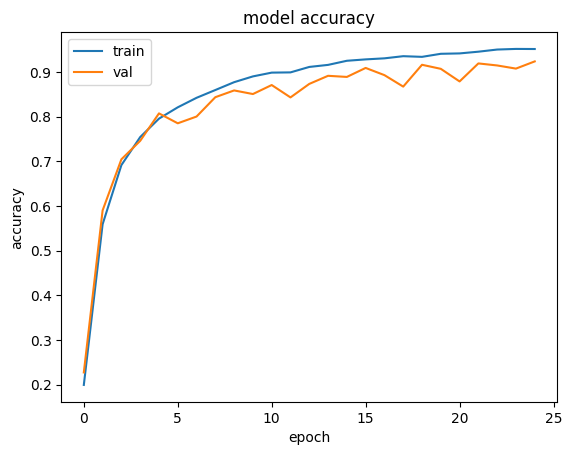

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

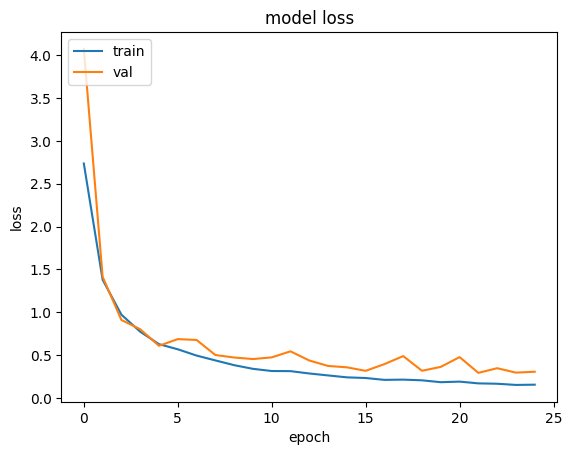

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_generator = DataGenerator(test_IDs, all_labels, **params)
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

31/31 [==============================] - 23s 735ms/step - loss: 0.2113 - accuracy: 0.9410
evaluate accuracy: 94.10%


-----------------

In [114]:
test_generator = DataGenerator(test_IDs, all_labels, **params)

test_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)

31/31 [==============================] - 25s 823ms/step


In [118]:
test_pred_created = []
for id in test_generator.get_classes().keys():
    img = cv2.imread(df[df['ID']==id].image.item())
    img = cv2.resize(img, (128, 128))
    img = preprocessing(img)
    test_pred_created.append(np.argmax(model.predict( np.array( [img,] ) , verbose=1 ), axis=1)[0])

1/1 [==============================] - 0s 25ms/step


In [125]:
precision = precision_score(list(test_generator.get_classes().values()), test_pred_created, average=None)
precision

array([0.95454545, 0.93478261, 0.95744681, 1.        , 0.92307692,
       0.97142857, 0.94285714, 0.89855072, 0.88235294, 0.90909091,
       0.875     , 0.87341772, 0.95555556, 0.72727273, 0.9047619 ,
       0.90909091, 0.85365854, 0.98039216, 0.87878788, 0.94488189,
       1.        , 1.        , 0.97916667, 0.75675676, 0.92682927,
       0.96610169, 0.87234043, 0.97560976, 0.94230769, 0.95744681,
       0.9516129 , 1.        ])

In [126]:
recall = recall_score(list(test_generator.get_classes().values()), test_pred_created, average=None)
recall

array([0.91304348, 0.97727273, 0.97826087, 1.        , 1.        ,
       0.89473684, 0.86842105, 0.96875   , 0.78947368, 1.        ,
       0.85365854, 0.88461538, 0.95555556, 0.82758621, 0.93442623,
       0.63829787, 0.97222222, 0.98039216, 0.95081967, 0.91603053,
       0.98333333, 0.94117647, 0.95918367, 0.88888889, 0.79166667,
       0.94214876, 0.97619048, 0.88888889, 0.89090909, 1.        ,
       0.96721311, 0.95774648])

In [127]:
f1 = f1_score(list(test_generator.get_classes().values()), test_pred_created, average=None)
f1

array([0.93333333, 0.95555556, 0.96774194, 1.        , 0.96      ,
       0.93150685, 0.90410959, 0.93233083, 0.83333333, 0.95238095,
       0.86419753, 0.87898089, 0.95555556, 0.77419355, 0.91935484,
       0.75      , 0.90909091, 0.98039216, 0.91338583, 0.93023256,
       0.99159664, 0.96969697, 0.96907216, 0.81751825, 0.85393258,
       0.9539749 , 0.92134831, 0.93023256, 0.91588785, 0.97826087,
       0.95934959, 0.97841727])

In [128]:
df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
df_results.index = cat_list

In [130]:
df_results

,Precision,Recall,F1
Airport,0.954545,0.913043,0.933333
BareLand,0.934783,0.977273,0.955556
BaseballField,0.957447,0.978261,0.967742
Beach,1.000000,1.000000,1.000000
Bridge,0.923077,1.000000,0.960000
Center,0.971429,0.894737,0.931507
Church,0.942857,0.868421,0.904110
Commercial,0.898551,0.968750,0.932331
DenseResidential,0.882353,0.789474,0.833333
Desert,0.909091,1.000000,0.952381
